In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import datetime as dt
df = pd.read_csv('cleaned_data.csv')
sns.set_palette(sns.color_palette("husl", 8))
plt.style.use("seaborn-darkgrid")

## Questions and Assumptions

We wanted to produce an analysis of the King Country Property Sales Data that would be useful to a number of people throughout the process of valuating a house. We will ask ourselves three different questions about the dataset based on data that homeowners, estate agents, and surveyors might have access to respectively. (As a secondary goal of our analysis, there are a number of guidelines from housing associations as to how various housing metrics affect house prices; we wanted to use these as a baseline and see whether our modelling could beat these coarse guidelines.)

Questions:
1. What is the relationship between basic size and quantity metrics and the price of a house? 
    * We imagined a homeowner coming to the estate agent with basic statistics about their house, and the estate agent being able to use our model in order to give them a decent prediction of how these metrics would affect their house price.
    * During our analysis we found that, for example the square footage of the property displayed too great a colinearity with the number of bedrooms for the two to be included as features in the same model. We had to look at these metrics individually in order to decide which was the more reliable for creating a model to predict house price. We do this with a pair plot between the size variables. 
    * We also tried a combination of the two of these features, square foot per bedroom to see if the relationship between the two was any more or less valid a model.

2. How much money could a homeowner get for their home if they spend the money to improve either its grade or condition?
    - We imagined a homeowner employing a surveyor to grade their house, and the surveyor being able to tell them whether it is worth it to spend the money on making the necessary improvements to move up a grade.
    - There are obvious caveats here, such as whether the spending will definitely guarantee an increase in the grading, but this certainty is also something that the model can give us some idea of.

3. Does recent renovation affect house prices?
    - If you have recently renovated your house, should you stay in it or sell it? (Much like the TV show Stay or Sell)
    - There are some major considerations with this question. If older houses are more expensive than newer ones in general, then a house that was renovated 60 years ago might be more expensive than a house built 10 years ago that has been recently renovated. 
    - This is limited by the fact that we don't know how much the renovation costs, but we hope to be able to give a general impression of whether it is worth it. 
    - We assume that a value of 0 for `yr_renovated` signifies that the property has not been renovated.

## Cleaning

#### NaN Values

In our cleaning we found that there were a number of missing values for the `waterfront` and `yr_renovated` variables. `waterfront` is a binary variable diplaying either a `1` or a `0` to show whether or not the property is on the waterfront. We decided that although the King Country area is by the sea, only a select few properties are right on the waterfront. For this reason it was easiest to assume that `nan` values for `waterfront` were not by the waterfront and therefor assign them `0`.

There were also a considerable amount of `nan` values for `yr_renovated`. In our analysis we are only going to be using using `yr_renovated` where there is a value for `yr_renovated` greater than 0, and we won't be dealing with, for example, median values of `yr_renovated` on its own. 

#### Dates

We also knew that we would want to use dates to see how prices change over time, but more importantly to see how long ago houses were renovated by subtracting the `yr_renovated` from the year in the `date` column. The formatting of the date as it was was not particularly robust as the date strings were different lengths (e.g. September is represented as _9_ not _09_). We converted the dates with pandas' built-in `parse_dates` argument for `read_csv`. 

#### Scaling

>_"When in doubt, take the log!"_ - Dan Sanz

With this being a sizeable dataset, with very large values for variables such as price, it seemed appropriate to take logarithms of some of our variables in order scale our data to make it more manageable. More importantly 'taking the log' will ensure that our input data has a normal distribution so that we have a greater chance of outputting normally distributed residuals from our model.

## Question 1 - Exploratory Data Analysis and Visualisation

The most effective way to predict the price of a property is by its size. It seems obvious that a bigger property is more expensive, but with linear regression we hope to be able to give an accurate description of the relationship between the two. In order to do this we need to consider the following:

- Which of the variables for size will make the best dependent variable with which to predict price?
- If we decide to add another feature and make our regression model multivariate, which feature will support the model best. Most features run the risk of multicolinearity.

#### Correlation, correlation, correlation

First of all lets have a look at a heatmap for price versus all of the other variables.

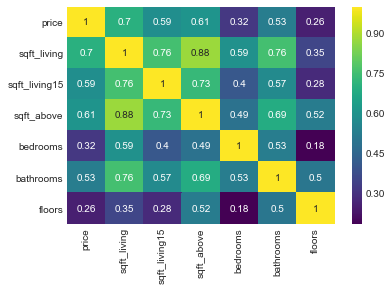

In [2]:
# First we make a new dataframe that of the pearson coefficient of each size variable and price against each other.
correlation_matrix = df[['price','sqft_living', 'sqft_living15','sqft_above', 'bedrooms', 'bathrooms','floors']].corr(method='pearson')
# Then we use seaboard's heatmap to display this information
sns.heatmap(correlation_matrix, cmap='viridis', annot=True)

The size metric which has the strongest correlation with price is the square footage of the living space, with a **Pearson Coefficient** of over 0.7. At a glance we can also see that `sqft_living` and `sqft_above` correlate very strongly with each other, meaning we won't be able to use both features in a multivariate regression without the danger of multicolinearity. 

#### The search for the second feature

If we want to see which second feature will fit well into our model we can't just look at the Pearson Coefficient between those two features, there is more to look at. This is where a **Pair Plot** will come in handy.

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


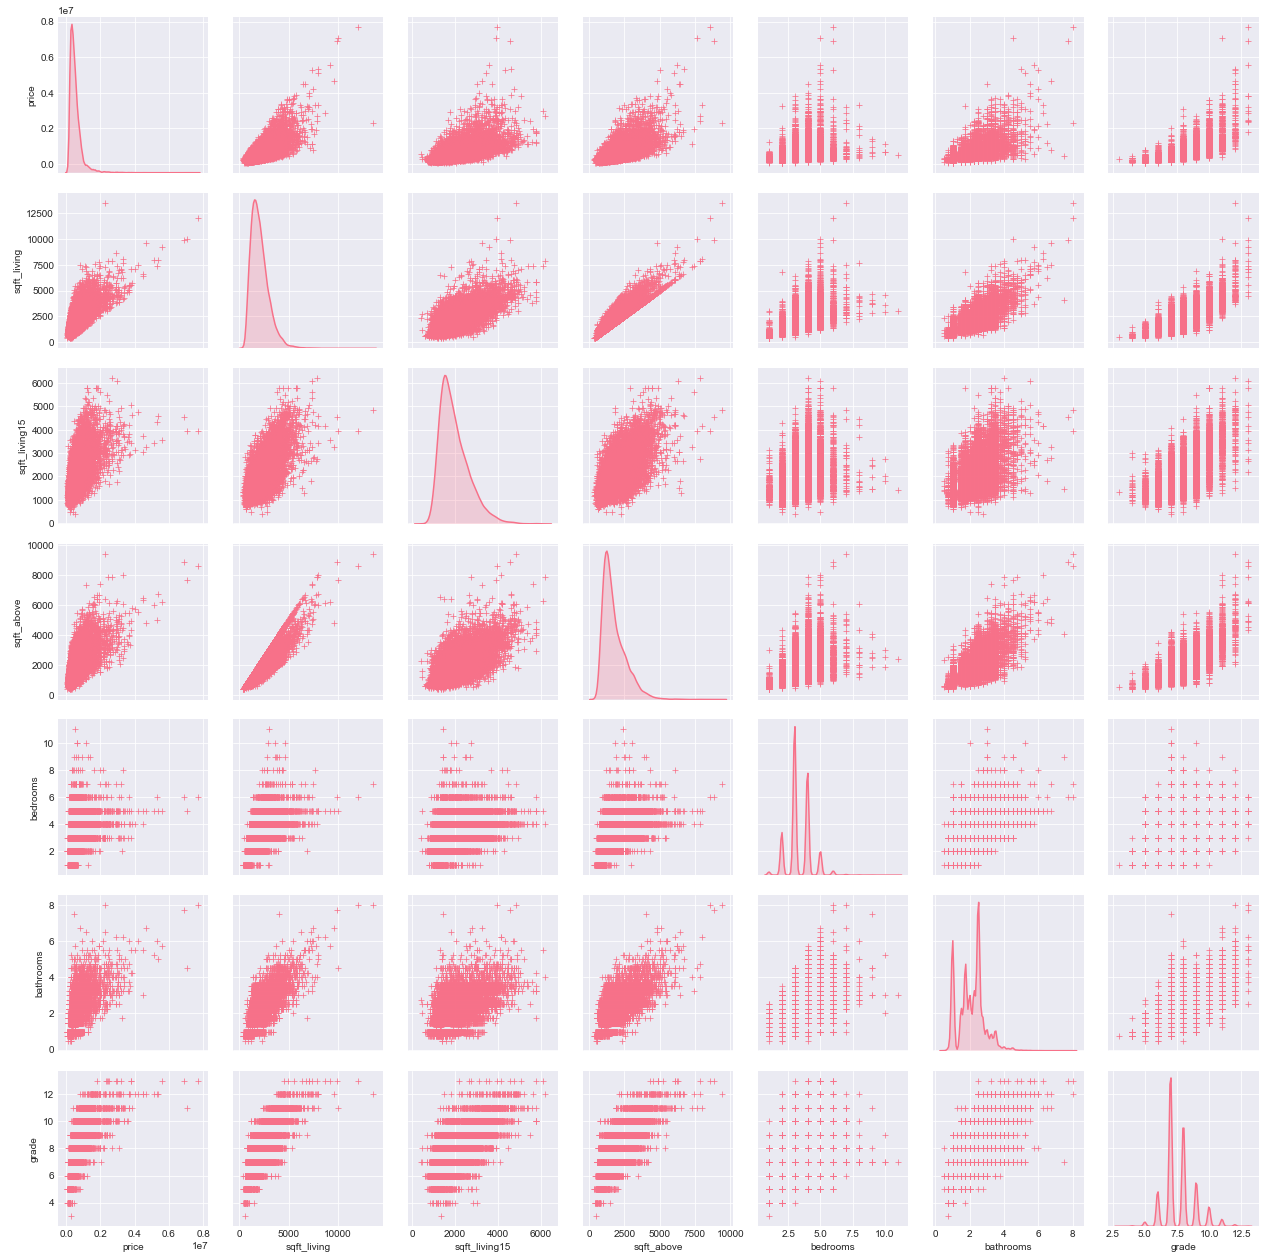

In [3]:
size_df = df[['price','sqft_living', 'sqft_living15','sqft_above', 'bedrooms', 'bathrooms', 'grade']]
sns.pairplot(size_df, diag_kind="kde", markers="+")

We want a second feature that correlates strongly with `price` but that doesn't correlate as strongly with `sqft_living`. The most obvious candidate for this is the `sqft_living15` or the square footage of the nearest fifteen properties to the property observed, which has both of these desired properties. We will also choose `grade` for this reason. 

Overview of population of housing in King's county for which we plot square foot 

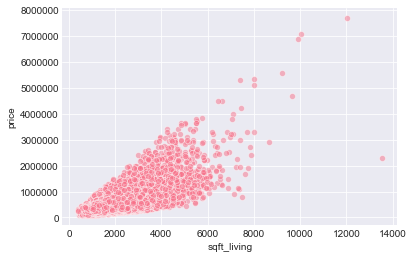

In [4]:
sns.scatterplot(df.sqft_living, df.price, alpha = 0.5)
plt.savefig('sqftvsprice.png')

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


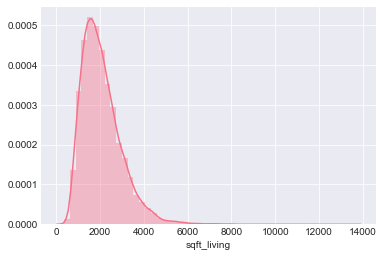

In [5]:
sns.distplot(df.sqft_living)
plt.savefig('sqftvsprice.png')

#### Log Time!

As price and square footage are both large units and are difficult to compare in scale, taking the log at this point will normalise these two variables. Lets look at the distribution before and after applying a logarithm to these variables.

//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Square Footage of Living Space')

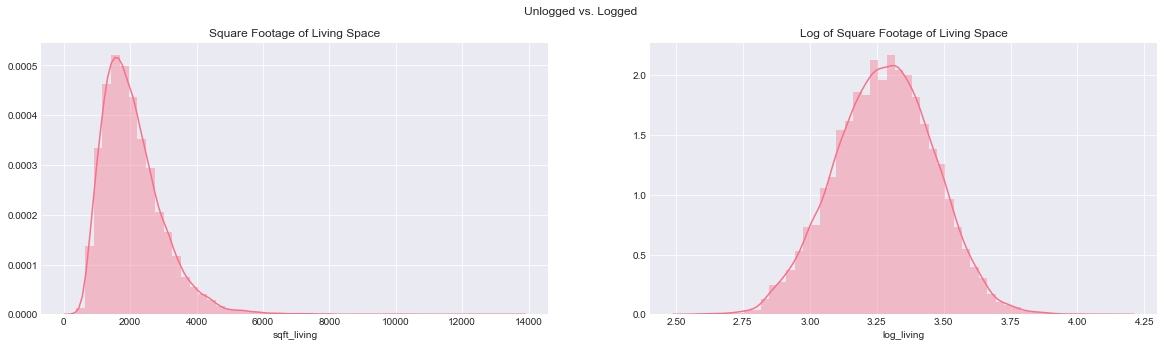

In [6]:
size_df['log_living'] = size_df['sqft_living'].map(lambda x: np.log10(x)) #This logs all of the values for 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.distplot(size_df['log_living'], ax=ax2).set_title('Log of Square Footage of Living Space')
plt.suptitle('Unlogged vs. Logged')
sns.distplot(size_df['sqft_living'], ax=ax1).set_title('Square Footage of Living Space')

The data for square footage of living space on its own has a strong positive skew. After applying a logarithm we see that the data is far more normally distributed. Now let's log the rest of the variables that we're going to be using: `price` and `sqft_living15`.

In [7]:
size_df['log_price'] = size_df['price'].map(lambda x: np.log10(x))
size_df['log_15'] = size_df['sqft_living15'].map(lambda x: np.log10(x))

//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Question 1 - Modelling

First we will make a model using our three parameters and assess its robustness. We will then make some changes to our data to see if we can approach a stronger model. 

In [8]:
# Setting our variables

y = size_df['log_price']

X = size_df.loc[:,['log_living', 'log_15', 'grade']]

# Setting up the LEARNER
X = sm.add_constant(X) #x is sqft_living
model_sm = sm.OLS(y,X)

# Actually LEARNING
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))

R2 = 0.55
const         3.3273
log_living    0.3520
log_15        0.1705
grade         0.0819
dtype: float64


Above we have coefficients for each of the features of the dataset, and because they are logs they represent percentage change. As well as a constant percentage increase of 7.6614. Below we'll make a qq-plot of our residuals to see how normally they are distributed.

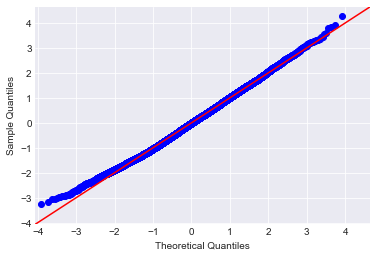

<Figure size 432x288 with 0 Axes>

In [9]:
residuals = results.resid
fig = sm.qqplot(residuals, line='45', fit=True)
plt.show()
plt.savefig('books_read.png')

At either end of the quartiles, our residuals start to part with our normality line. This suggests that if we prune our data for outliers we can get a line that is more general. We would also like to improve on our r-squared of 0.55

#### Dealing with outliers

## Question 2 - Exploratory Data Analysis and Visualisation

While continuous data is king, categorical data brings its own charms. Consideration of the categorical data in the set allows us to ask pertinent questions such as whether it is worth improving the condition or grade of your house before selling it. 

#### Condition

Looking at the [King County Assessment Roll](https://www.kingcounty.gov/depts/assessor/~/media/depts/Assessor/documents/AreaReports/2018/Residential/015.ashx) (p. 30) gives us a rundown of how condition and grade are assessed.

Condition:

1. Poor - Many repairs needed. Showing serious deterioration.
2. Fair - Some repairs needed immediately. Much deferred maintenance.
3. Average - Depending upon age of improvement; normal amount of upkeep for the age of the home.
4. Good - Condition above the norm for the age of the home. Indicates extra attention and care has been taken to maintain.
5. Very Good - Excellent maintenance and updating on home. Not a total renovation.


Although this doesn't give us a surfeit of information, we can at least guess that the difference between a condition of 1 and 2 are probably smaller than conditions 2 and 3. If this is so then we would expect to see a larger jump in price between conditions 2 and 3. If we can tell how much these jumps in prices are then we can give people an idea of whether it is worth making the necessary renovation to their houses. 


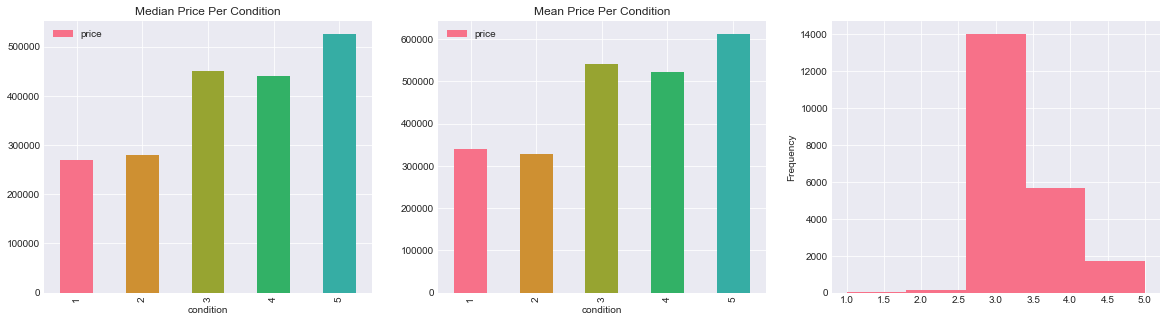

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5)) 

condition_median = df.groupby('condition').median()
condition_mean = df.groupby('condition').mean()

condition_median.plot.bar(y='price', ax=ax1).set_title('Median Price Per Condition')
condition_mean.plot.bar(y='price', ax=ax2).set_title('Mean Price Per Condition')
df.condition.plot.hist(ax=ax3, bins=5)
plt.savefig('conditionimprovement')

The jump in mean and median price between conditions 2 or 3 is quite considerable. However we've included a second third plot examining the distributions of these grades, which will serve as a cautionary tale about the nature as to how much we can trust our averages. For example although both average prices for condition 3 are higher, there is far more price data for condition 3 than any other condition. This does let us make the observation that the 'default' value for condition ratings in King County appears to be 3. If you do happen to find yourself in the unfortunate position of having a house in 2 condition then it seems fairly likely that renovation would be worthwhile.

#### Grade
Now let's take a look at the grading system:

1-3. Falls short of minimum building standards. Normally cabin or inferior structure.
4. Generally older low quality construction. Does not meet code.
5. Lower construction costs and workmanship. Small, simple design.
6. Lowest grade currently meeting building codes. Low quality materials, simple designs.
7. Average grade of construction and design. Commonly seen in plats and older subdivisions.
8. Just above average in construction and design. Usually better materials in both the exterior and interior finishes.
9. Better architectural design, with extra exterior and interior design and quality.
10. Homes of this quality generally have high quality features. Finish work is better, and more design quality is seen in the floor plans and larger square footage.
11. Custom design and higher quality finish work, with added amenities of solid woods, bathroom fixtures and more luxurious options.
12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
13. Generally custom designed and built. Approaching the Mansion level. Large amount of highest quality cabinet work, wood trim and marble; large entries.

Looking at the grading system we see a number of limitations, for example it seems impossible for a small apartment to have a grading of 13. Nonetheless we can get a good understanding of whether it is worth it to get the necessary renovations to get that jump in grading.

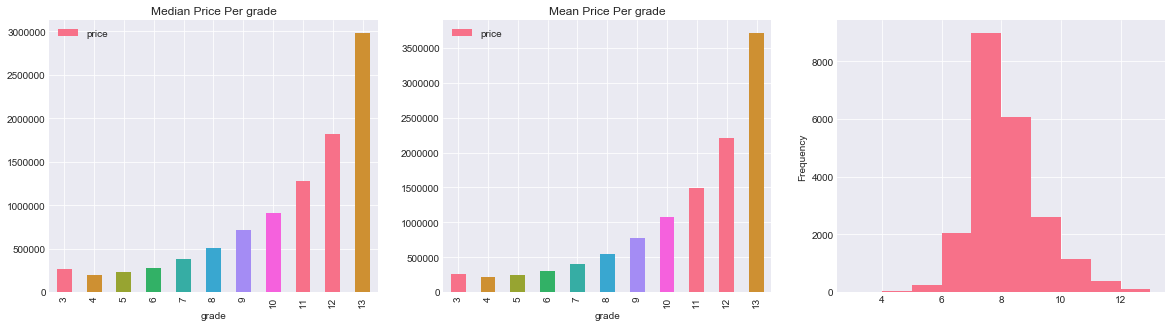

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5)) 

grade_median = df.groupby('grade').median()
grade_mean = df.groupby('grade').mean()

grade_median.plot.bar(y='price', ax=ax1).set_title('Median Price Per grade')
grade_mean.plot.bar(y='price', ax=ax2).set_title('Mean Price Per grade')
df.grade.plot.hist(ax=ax3)

We can see that a majority of properties have a grading of 7, and so the most obvious question is whether its worth the renovations to get from the 7 group to the 8 group, which seems like a possible improvement for most of these properties.

In [12]:
median_gain = grade_median['price'].loc[8] - grade_median['price'].loc[7] #Median Price Difference
mean_gain = grade_mean['price'].loc[8] - grade_mean['price'].loc[7] #Mean Price Difference

print('The median price gain between grades 7 and 8 is {} and the mean price gain is {}'.format(median_gain, round(mean_gain)))

The median price gain between grades 7 and 8 is 135000.0 and the mean price gain is 140419.0


In [13]:
mean_gain_p_sqft = mean_gain/grade_mean['sqft_living'].loc[7] #A rough estimate for the difference in price per square footage.

In [14]:
1500 * mean_gain_p_sqft #Trying this with a very common square footage

124667.17972001088

In [15]:
df.loc[(df['grade'] == 7) & (df['sqft_living'] ==1500)].describe().round() # Looking for the mean price for this exact square footage and grade 7

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,77.0,7.700000e+01,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,63.0,77.0,77.0,77.0,77.0,77.0
mean,10851.0,4.387379e+09,377334.0,3.0,2.0,1500.0,7250.0,1.0,0.0,0.0,3.0,7.0,1310.0,1962.0,0.0,98076.0,48.0,-122.0,1578.0,7276.0
std,5985.0,2.572858e+09,135713.0,1.0,1.0,0.0,3745.0,1.0,0.0,0.0,1.0,0.0,232.0,29.0,0.0,52.0,0.0,0.0,243.0,3852.0
min,689.0,1.045010e+08,182568.0,2.0,1.0,1500.0,1119.0,1.0,0.0,0.0,2.0,7.0,750.0,1900.0,0.0,98001.0,47.0,-122.0,980.0,1057.0
25%,7072.0,2.473101e+09,270000.0,3.0,2.0,1500.0,4158.0,1.0,0.0,0.0,3.0,7.0,1110.0,1945.0,0.0,98031.0,47.0,-122.0,1480.0,4500.0
50%,11049.0,4.427100e+09,352500.0,3.0,2.0,1500.0,7200.0,1.0,0.0,0.0,3.0,7.0,1500.0,1968.0,0.0,98058.0,48.0,-122.0,1500.0,7272.0
75%,16281.0,6.648000e+09,435000.0,3.0,2.0,1500.0,9656.0,2.0,0.0,0.0,4.0,7.0,1500.0,1983.0,0.0,98117.0,48.0,-122.0,1700.0,8374.0
max,21346.0,9.307300e+09,782000.0,5.0,4.0,1500.0,19113.0,3.0,0.0,2.0,5.0,7.0,1500.0,2014.0,0.0,98199.0,48.0,-122.0,2700.0,20800.0


In [16]:
df.loc[(df['grade'] == 8) & (df['sqft_living'] ==1500)].describe().round() # Looking for the mean price for this exact square footage and grade 8

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,18.0,1.800000e+01,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,16.0,18.0,18.0,18.0,18.0,18.0
mean,14013.0,3.731851e+09,468997.0,3.0,2.0,1500.0,4931.0,2.0,0.0,0.0,3.0,8.0,1376.0,1987.0,0.0,98099.0,48.0,-122.0,1718.0,4442.0
std,6670.0,2.613038e+09,156640.0,0.0,1.0,0.0,4576.0,1.0,0.0,1.0,1.0,0.0,166.0,25.0,0.0,45.0,0.0,0.0,275.0,2922.0
min,867.0,4.000047e+07,170000.0,2.0,1.0,1500.0,761.0,1.0,0.0,0.0,3.0,8.0,1100.0,1933.0,0.0,98023.0,47.0,-122.0,1360.0,1282.0
25%,11202.0,1.972202e+09,410500.0,2.0,2.0,1500.0,1344.0,1.0,0.0,0.0,3.0,8.0,1225.0,1974.0,0.0,98095.0,48.0,-122.0,1500.0,1612.0
50%,15579.0,2.767952e+09,482250.0,3.0,2.0,1500.0,3804.0,2.0,0.0,0.0,3.0,8.0,1500.0,1999.0,0.0,98107.0,48.0,-122.0,1710.0,4204.0
75%,19533.0,5.046888e+09,525000.0,3.0,2.0,1500.0,7392.0,2.0,0.0,0.0,3.0,8.0,1500.0,2006.0,0.0,98121.0,48.0,-122.0,1935.0,7193.0
max,21566.0,9.126100e+09,765000.0,3.0,4.0,1500.0,18540.0,3.0,0.0,3.0,5.0,8.0,1500.0,2014.0,0.0,98177.0,48.0,-122.0,2380.0,9500.0


In [17]:
468997 - 377334 # Price difference for 1500 sqft between grades 7 & 8

91663

If you can get your renovation at anywhere under this cost per square foot it seems fairly likely that it would be worth it to go ahead! There are obvious caveats, as our model above shows house prices vary on much more than just square footage, but hopefully this gives some idea of the jump in prices between conditions and grades. 

## Question 3 - Exploratory Data Analysis and Visualisation

Our third question is somewhat similar to our last question. We were in part inspired by the television 'Stay or Sell' in which a homeowner is given two options for improving their living circumstances; they can either renovate the house they already live in, or move to a new house. Our question is slightly different, it instead looks at how recently a house was renovated and asks whether it is best to stay in your newly renovated home, or whether the improvements in your house have improved its value enough for you to trade up to a new house. 

Firstly as we explained in our **Data Cleaning** section, we had to reformat our `date` column in order to get it to play ball. We then make a subsection of the houses that have actually been renovated and then subtract the year renovated from the date sold in order to see how long before the sale the house was renovated. We'll show how we did this below. 

In [18]:
renovated_df = df[df['yr_renovated']>0] 
renovated_df = renovated_df.dropna(subset=['yr_renovated'], axis=0) # Making ourselves a subset of renovated properties

renovated_df['date'] = renovated_df['date'].map(lambda x: dt.datetime.strptime(str(x),'%m/%d/%Y').strftime('%d/%m/%Y')) # Converting to a more manageable time format.
years_sold = [float(x[6:11]) for x in renovated_df.date] #Targeting just the year from the date string
years_renovated = [x for x in renovated_df.yr_renovated] # Getting the years renovated

sold_array = np.array(years_sold) # Making arrays
renovated_array = np.array(years_renovated)

years_ago = sold_array - renovated_array

renovated_df['renovated_yrs_ago'] = years_ago

renovated_df['renovated_yrs_ago'].value_counts()# Having a look at the value counts. 

0.0     68
1.0     37
8.0     34
10.0    29
11.0    27
15.0    23
7.0     21
12.0    21
14.0    21
31.0    20
25.0    20
9.0     19
24.0    19
5.0     18
26.0    18
13.0    16
6.0     16
16.0    16
20.0    15
28.0    15
29.0    15
23.0    14
21.0    14
22.0    13
2.0     13
4.0     13
17.0    12
19.0    12
32.0    11
27.0    10
        ..
45.0     5
51.0     4
33.0     4
41.0     4
40.0     4
38.0     4
59.0     4
58.0     3
69.0     3
56.0     3
52.0     3
42.0     3
36.0     3
47.0     3
74.0     2
43.0     2
70.0     2
54.0     2
39.0     2
49.0     2
55.0     2
48.0     1
65.0     1
57.0     1
60.0     1
53.0     1
64.0     1
66.0     1
80.0     1
61.0     1
Name: renovated_yrs_ago, Length: 70, dtype: int64

In [19]:
renovated_df.groupby('renovated_yrs_ago').mean().round()

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
renovated_yrs_ago,,,,,,,,,,,,,,,,,,,,
-1.0,11675.0,6.874167e+09,637667.0,4.0,3.0,3183.0,14424.0,1.0,0.0,2.0,3.0,8.0,2190.0,1940.0,2015.0,98148.0,48.0,-122.0,2362.0,12066.0
0.0,8734.0,4.480442e+09,676600.0,4.0,2.0,2200.0,7427.0,1.0,0.0,0.0,3.0,8.0,1610.0,1942.0,2014.0,98107.0,48.0,-122.0,1818.0,7159.0
1.0,10534.0,5.430533e+09,629492.0,4.0,2.0,2018.0,7681.0,1.0,0.0,0.0,3.0,7.0,1542.0,1940.0,2013.0,98111.0,48.0,-122.0,1686.0,6904.0
2.0,10099.0,2.488872e+09,804331.0,3.0,2.0,1966.0,7632.0,1.0,0.0,1.0,3.0,8.0,1466.0,1941.0,2013.0,98094.0,48.0,-122.0,1850.0,9303.0
3.0,9149.0,3.783135e+09,542083.0,3.0,2.0,1632.0,4102.0,1.0,0.0,0.0,3.0,7.0,1228.0,1931.0,2011.0,98105.0,48.0,-122.0,1484.0,4433.0
4.0,7292.0,3.609590e+09,844388.0,4.0,3.0,2469.0,7423.0,2.0,0.0,0.0,3.0,8.0,2000.0,1946.0,2010.0,98076.0,48.0,-122.0,1996.0,7505.0
5.0,12383.0,3.846843e+09,1132556.0,3.0,2.0,2756.0,8850.0,2.0,0.0,1.0,3.0,8.0,2212.0,1956.0,2009.0,98096.0,48.0,-122.0,2229.0,8580.0
6.0,11886.0,4.033630e+09,759843.0,4.0,2.0,2336.0,22043.0,2.0,0.0,0.0,3.0,8.0,1783.0,1950.0,2008.0,98087.0,48.0,-122.0,1837.0,14065.0
7.0,10723.0,3.994709e+09,1051462.0,4.0,3.0,2947.0,22828.0,2.0,0.0,1.0,3.0,8.0,2272.0,1945.0,2007.0,98083.0,48.0,-122.0,2179.0,17171.0


This data on its own, unfortunately doesn't tell us much. We can see that the mean prices for each of the values of `renovated_yrs_ago` vary wildly and show now real correlation. In ordet to get a better picture we need to compare like properties. So let's subset by square footage to see if there's any correlation between houses of the same size. We'll do this by looking at the interquartile range for house sizes for the population.

In [20]:
iq_group = renovated_df.loc[(renovated_df['sqft_living'] >= 1430) & (renovated_df['sqft_living'] <= 2550)]
iq_group.groupby('renovated_yrs_ago').mean().round()

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
renovated_yrs_ago,,,,,,,,,,,,,,,,,,,,
-1.0,2293.0,8.712100e+09,585000.0,5.0,3.0,2350.0,4178.0,2.0,0.0,0.0,3.0,8.0,1520.0,1922.0,2015.0,98112.0,48.0,-122.0,1920.0,4178.0
0.0,8503.0,4.683009e+09,636448.0,4.0,2.0,1965.0,6670.0,1.0,0.0,0.0,3.0,7.0,1368.0,1942.0,2014.0,98106.0,48.0,-122.0,1821.0,6782.0
1.0,10651.0,5.186837e+09,683031.0,4.0,2.0,2126.0,7628.0,2.0,0.0,0.0,3.0,8.0,1579.0,1942.0,2013.0,98117.0,48.0,-122.0,1791.0,6554.0
2.0,9509.0,1.374894e+09,667100.0,3.0,3.0,2100.0,8085.0,2.0,0.0,0.0,3.0,8.0,1602.0,1948.0,2013.0,98083.0,48.0,-122.0,1730.0,11644.0
3.0,7275.0,4.428251e+09,509958.0,3.0,2.0,1795.0,4627.0,1.0,0.0,0.0,3.0,7.0,1188.0,1934.0,2011.0,98102.0,48.0,-122.0,1325.0,5094.0
4.0,9004.0,4.746701e+09,665367.0,3.0,2.0,1960.0,7473.0,1.0,0.0,0.0,3.0,7.0,1330.0,1943.0,2010.0,98082.0,48.0,-122.0,1877.0,7187.0
5.0,13482.0,3.194552e+09,489250.0,3.0,2.0,1692.0,7268.0,1.0,0.0,0.0,3.0,8.0,1692.0,1951.0,2009.0,98096.0,48.0,-122.0,1542.0,7944.0
6.0,13888.0,3.667882e+09,532070.0,3.0,2.0,1974.0,41816.0,1.0,0.0,0.0,3.0,7.0,1423.0,1961.0,2008.0,98076.0,48.0,-122.0,1824.0,23872.0
7.0,10761.0,3.030520e+09,568838.0,3.0,2.0,1998.0,18744.0,1.0,0.0,0.0,3.0,7.0,1641.0,1943.0,2007.0,98082.0,48.0,-122.0,1645.0,9135.0
